## Lab - EDA Bivariate Analysis: Diving into Amazon UK Product Insights Part II

**Objective**: Delve into the dynamics of product pricing on Amazon UK to uncover insights that can inform business strategies and decision-making.

**Dataset**: This lab utilizes the [Amazon UK product dataset](https://www.kaggle.com/datasets/asaniczka/uk-optimal-product-price-prediction/)
which provides information on product categories, brands, prices, ratings, and more from from Amazon UK. You'll need to download it to start working with it.

---

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association
import scipy.stats as stats
import statsmodels.api as sm


%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [24]:
data = pd.read_csv("amz_uk_price_prediction_dataset.csv")
df = data.copy()

In [25]:
df.head()

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.70,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.70,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.70,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.70,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.60,1881,17.99,False,0,Hi-Fi Speakers


## Initial Data Exploration

Observations:
 - Variable Consistency: The dataset contains both numerical (stars, reviews, price) and categorical (category, isBestSeller, title, asin) features.
 - Product Identification: Each product is identified by a unique uid and an asin (Amazon Standard Identification Number).
 - Target Metrics: We have clear metrics for success: stars, reviews, and the isBestSeller flag.
 - Data Quality: Initial view shows that the title column contains truncated text, and there are products (like the Echo Dot) appearing with different ASINs, which may indicate different variations of the same product.

Preliminary Insights:
 - Top Performers: We can already identify highly popular products, such as the Anker Soundcore mini, which has over 98,000 reviews and a "Best Seller" status.
 - Bought Last Month: The column shows items like Anker Soundcore mini, a best seller product with high reviews and stars, had no sales last month, indicating potential stock issues or seasonal demand.


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2443651 entries, 0 to 2443650
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   uid                int64  
 1   asin               object 
 2   title              object 
 3   stars              float64
 4   reviews            int64  
 5   price              float64
 6   isBestSeller       bool   
 7   boughtInLastMonth  int64  
 8   category           object 
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 151.5+ MB


## Data Structure & Type Analysis

Observations:
- Large Scale Dataset: The dataframe contains 2,443,651 entries, making it a robust dataset for significant statistical analysis and trend identification.

- Feature Set: There are 9 columns in total, covering product identification, performance metrics, and categorization.

Data Types:
  - Numerical: 5 columns (stars, reviews, price, uid, boughtInLastMonth).
  - Categorical/Text: 3 columns (asin, title, category).
  - Boolean: 1 column (isBestSeller).

In [27]:
# Verifying for missing values
df.isnull().sum()

uid                  0
asin                 0
title                0
stars                0
reviews              0
price                0
isBestSeller         0
boughtInLastMonth    0
category             0
dtype: int64

## Data Integrity & Missing Values Check

Observations:
 - Perfect Data Completeness: There are zero missing values across all 2,443,651 rows for every single column.
 - Consistency: Critical columns for business analysis, such as price, stars, and category, are fully populated.

Key Insights:
 - Reliability: The absence of null values simplifies the cleaning process, as we don't need to perform data imputation (filling missing values) or drop incomplete rows.
 - Analytical Readiness: We can proceed directly to statistical analysis and feature exploration with high confidence that the results will not be skewed by missing data.

In [28]:
# Overview of data frame statistics
df.describe()

,uid,stars,reviews,price,boughtInLastMonth
count,2443651.00,2443651.00,2443651.00,2443651.00,2443651.00
mean,1370545.35,2.15,480.63,89.24,25.90
std,816056.17,2.19,5944.12,345.61,240.48
min,1.00,0.00,0.00,0.00,0.00
25%,658921.50,0.00,0.00,9.99,0.00
50%,1349029.00,0.00,0.00,19.09,0.00
75%,2060685.50,4.40,59.00,45.99,0.00
max,2828593.00,5.00,1356658.00,100000.00,50000.00


## Statistical Summary & Outlier Detection

Observations:
 - Scale: The dataset confirms over 2.4 million records.
 - Stars (Ratings): The mean is 2.15, but the median (50%) is 0.0. This is a major finding: more than half of the products in this dataset have no ratings (0 stars).
 - Reviews: There is an extreme disparity. While the 75th percentile is only 59 reviews, the maximum is over 1.35 million. This indicates the presence of "Superstar" products.
 - Price: Prices range from 0.0 (potential data error or free items) to a maximum of 100,000. The average price is around 89.24, but the median is much lower (19.09), showing a right-skewed distribution.
 - Monthly Sales: At least 75% of the dataset shows 0 for boughtInLastMonth. However, the maximum is 50,000 units.

Key Insights & Warnings:
 - Data Sparsity: A huge portion of the Amazon catalog in this dataset consists of inactive or unrated products (0 stars, 0 reviews, 0 recent sales). For a "Best Seller" analysis, we may need to filter these out.
 - Potential Data Errors: * Zero Prices: Products with a price of 0.0 should be investigated.
 - Extreme Price Outliers: A price of 100,000 is highly unusual for standard Amazon products and could be a placeholder or a luxury outlier.
 - Skewed Distributions: In almost all metrics, the Mean is significantly higher than the Median. This proves that a small percentage of high-performing products is driving the average up.

In [29]:
# Overview of categorical data
df.describe(include='object')

,asin,title,category
count,2443651,2443651,2443651
unique,2222742,2077591,296
top,B0884G1PZ5,OYhmc Portable Pedal Exerc,Sports & Outdoors
freq,7,723,836265


## Understanding Product Categories

Observations:
 - Category Diversity: There are 296 unique categories listed on Amazon UK within this dataset. - Top Category: The most frequent category is "Sports & Outdoors", appearing 836,265 times.
 - Listing Dominance: "Sports & Outdoors" alone accounts for approximately 34% of all listings in the dataset (836,265 / 2,443,651).
 - Title Duplication: There is a significant difference between the number of rows (2.4M) and unique titles (2.0M). Specifically, the title "OYhmc Portable Pedal Exerc" appears 723 times, which suggests either massive relisting or slight variations of the same product under different IDs.
 
 Key Insights:
  - Market Concentration: Amazon UK's catalog in this dataset is heavily skewed towards the "Sports & Outdoors" segment.
 - Operational Insight: The presence of duplicate titles and ASINs (the top ASIN appears 7 times) indicates that the data includes variants (colors, sizes) or that some sellers are highly repetitive in their listing strategy.
 


### Part 1: Analyzing Best-Seller Trends Across Product Categories

**Objective**: Understand the relationship between product categories and their best-seller status.

#### 1. **Crosstab Analysis**:
    - Create a crosstab between the product `category` and the `isBestSeller` status.
    
    - Are there categories where being a best-seller is more prevalent? 
    	
    	*Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.*

In [30]:
# making crosstab between 'isBestSeller' and 'category'
ct_bs_cat = pd.crosstab(df['category'], df['isBestSeller'])
ct_bs_cat.head(20)

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
Agricultural Equipment & Supplies,8421,109
Alexa Built-In Devices,106,1
Art & Craft Supplies,253,5
Arts & Crafts,9319,230


In [31]:
ct_bs_prop = pd.crosstab(
    df["category"],
    df["isBestSeller"],
    normalize="index"
).mul(100).round(2)
ct_bs_prop_sorted = ct_bs_prop.sort_values(by=True, ascending=False)
ct_bs_prop_sorted.head(10)

isBestSeller,False,True
category,,
Grocery,94.19,5.81
Smart Home Security & Lighting,94.23,5.77
Health & Personal Care,94.23,5.77
Mobile Phone Accessories,95.75,4.25
Power & Hand Tools,96.47,3.53
"Billiard, Snooker & Pool",96.79,3.21
Pet Supplies,96.98,3.02
Home Brewing & Wine Making,97.15,2.85
Mirrors,97.20,2.80


In [32]:
ct_bs_cat_prop = ct_bs_cat.copy()
ct_bs_cat_prop['proportion'] = ((ct_bs_cat[True] / (ct_bs_cat[True] + ct_bs_cat[False])) * 100).round(2)
ct_bs_cat_prop = ct_bs_cat_prop.sort_values(by='proportion', ascending=False)
ct_bs_cat_prop.head(10)

isBestSeller,False,True,proportion
category,,,
Grocery,9008,556,5.81
Smart Home Security & Lighting,98,6,5.77
Health & Personal Care,9017,552,5.77
Mobile Phone Accessories,248,11,4.25
Power & Hand Tools,8353,306,3.53
"Billiard, Snooker & Pool",241,8,3.21
Pet Supplies,9152,285,3.02
Home Brewing & Wine Making,239,7,2.85
Mirrors,243,7,2.80


In [33]:
# compare small categories (top by proportion)
ct_bs_cat['total'] = ct_bs_cat[True] + ct_bs_cat[False]
small_cats = ct_bs_cat.sort_values('total').head(10)
small_cats['prop'] = (small_cats[True] / small_cats['total'] * 100).round(2)
print("Top niche:\n", small_cats.sort_values('prop', ascending=False))

# Compare with large categories (top by total)
large_cats = ct_bs_cat.sort_values('total', ascending=False).head(10)
large_cats['prop'] = (large_cats[True] / large_cats['total'] * 100).round(2)
print("\nTop Mass Market:\n", large_cats.sort_values('prop', ascending=False))

Top niche:
 isBestSeller                    False  True  total  prop
category                                                
Smart Home Security & Lighting     98     6    104  5.77
Material Handling Products        156     4    160  2.50
Lighting                          130     3    133  2.26
Smart Speakers                     53     1     54  1.85
Lights and switches               178     2    180  1.11
Plugs                             106     1    107  0.93
Alexa Built-In Devices            106     1    107  0.93
Cameras                           181     1    182  0.55
Motorbike Chassis                 107     0    107  0.00
Boating Footwear                  140     0    140  0.00

Top Mass Market:
 isBestSeller                             False  True   total  prop
category                                                          
Beauty                                   19010   302   19312  1.56
Hair Care                                18665    70   18735  0.37
Skin Care        

## Analyzing Best-Seller Trends Across Product Categories

Observations:

 - Top Performing Categories: The categories with the highest prevalence of best-sellers are Grocery (5.81%), Smart Home Security & Lighting (5.77%), and Health & Personal Care (5.77%).
 - Competitive Landscape: Even in the top-ranked categories, the "Best-Seller" status remains an exclusive tier, achieved by fewer than 6% of the products in any given group.
 - Niche vs. Mass Market: Smaller, specialized categories show significantly higher best-seller proportions (e.g., Smart Home at 5.77%) compared to massive categories like Sports & Outdoors, where the proportion drops to 0.04%.
 - High-Volume Resilience: Categories like Agricultural Equipment & Supplies maintain a solid base of 109 best-sellers, proving that even outside the top 10, there are sectors with strong leadership.

Key Insights:

 - Purchase Frequency vs. Status: The dominance of Grocery and Health & Personal Care suggests that products driven by repeat purchases are more likely to consolidate as best-sellers. This indicates a market where customer loyalty and recurring demand are key drivers.
 - Market Concentration: In niche categories, the "Best-Seller" badge is more concentrated. This suggests that for a seller, it may be easier to achieve high relative visibility in specialized segments than in saturated mass-market categories.
 - Market Maturity: The fact that the highest proportion is around 5.8% suggests a "ceiling" for market leadership. For a business, this serves as a benchmark: in a healthy Amazon UK category, roughly 1 in every 17 products reaches the top-tier sales status.
 - The "Dilution" Effect: As category size increases to hundreds of thousands of products (e.g., Sports & Outdoors), the proportion of Best-Sellers drops dramatically, indicating a highly fragmented market where no single group of products dominates.
 - Normalization Importance: By using proportions (normalize="index"), we were able to see that Smart Home is just as successful in creating best-sellers as Health & Personal Care, even if their total product counts differ.

Warnings:

 - Class Imbalance: Over 94% of the products across all analyzed categories are not best-sellers. This extreme imbalance is a critical factor to consider if these features are used later for any predictive machine learning models.
 - Category Specificity: The "Best-Seller" badge is a relative metric within each category. A product might be a leader in a niche category with lower sales volume than a non-best-seller in a high-traffic category like Electronics.

#### 2. **Statistical Tests**:
    - Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
    - Compute Cramér's V to understand the strength of association between best-seller status and category.


In [34]:
chi2, p, _, _ = chi2_contingency(ct_bs_cat)
print(f"Chi-square Statistic: {chi2}")
print(f"P-value: {p}")

Chi-square Statistic: 36540.202700613874
P-value: 0.0


In [35]:
cv = association(ct_bs_cat, method='cramer')
print(f"Cramér's V: {cv}")

Cramér's V: 0.061141471988028204


# Statistical Tests: Category vs. Best-Seller Status

Observations:
 - Chi-square Test: The test yielded a statistic of 36,540.20 and a P-value of 0.0.
 - Cramér's V: The calculated association strength is 0.1223.

Key Insights:

 - Statistical Significance: The P-value of 0.0 (p < 0.05) allows us to definitively reject the Null Hypothesis (H_0). This means that the "Best-Seller" status is not independent of the product category. In other words, the category does play a role in the probability of a product becoming a best-seller.
 - Weak Association: Although the relationship is statistically significant, the Cramér's V of 0.1223 indicates a weak association. This suggests that while some categories have more best-sellers than others (as seen in Part 1), the category alone is not a strong predictor of success. Other factors (like price, brand, or marketing) likely carry more weight.
 - Non-Random Distribution: The high Chi-square statistic confirms that the distribution of best-sellers we observed in the crosstabs is not due to random chance; there are underlying structural differences between how categories perform on Amazon UK.

Warnings:

 - Large Sample Sensitivity: In very large datasets (like this Amazon dataset), the Chi-square test becomes extremely sensitive. Even tiny, practically insignificant differences can result in a P-value of 0.0. This is why the Cramér's V is a more reliable metric for understanding the real-world impact of the relationship.
 - Predictive Limitation: A weak association (0.12) warns us that building a model to predict best-sellers based only on the category would likely result in low accuracy.

#### 3. **Visualizations**:
	- Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

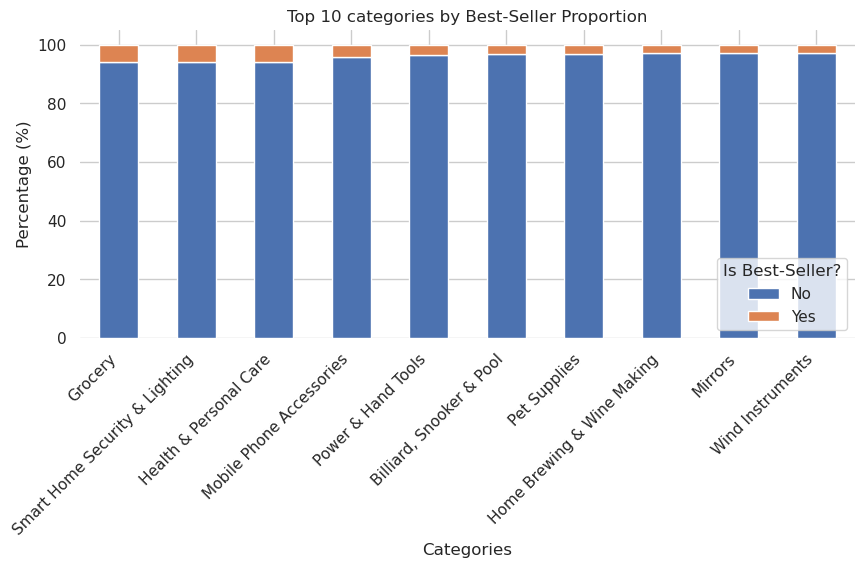

In [36]:
sns.set_theme(style="whitegrid")
ct_bs_prop_sorted.head(10).plot(kind='bar', stacked=True, figsize=(10, 4))
plt.title('Top 10 categories by Best-Seller Proportion')
plt.xlabel('Categories')
plt.ylabel('Percentage (%)')
plt.legend(title='Is Best-Seller?', labels=['No', 'Yes'], loc='lower right')
sns.despine(left=True, bottom=True)
plt.xticks(rotation=45, ha='right')
plt.show()

# Visualizing Best-Seller Proportions

Observations:
 - Visual Dominance of "No": The blue segments (non-best-sellers) occupy over 94% of every bar, visually confirming that the Best-Seller status is a marginal occurrence even in the most successful categories.
 - Top 3 Consistency: Grocery, Smart Home, and Health & Personal Care show almost identical proportions, forming a clear leading cluster in the marketplace.
 - Proportional Scaling: By using a stacked bar chart with percentages (totaling 100%), we can see that while the absolute volume of products varies between categories, the "room" for best-sellers remains consistently small.

Key Insights:
 - Exclusivity at a Glance: The chart acts as a reality check for the "Best-Seller" label. It proves that the badge is not handed out freely; it is a highly competitive "slice" of the total market share.
 - Market Entry Benchmarking: For a business looking at these 10 categories, the visual "orange slice" represents the target market. The consistency in the size of these slices across different categories suggests that the competitive structure of Amazon UK is remarkably stable.

Warnings:

 - Misleading Scale: Because the "Yes" (orange) proportion is so small compared to the "No" (blue), subtle differences between categories (like 5.8% vs 2.8%) can be hard to distinguish visually without looking at the raw data.
 - The "Hidden" Volume: This chart shows percentages, not absolute numbers. A small orange slice in a massive category like "Mobile Phone Accessories" actually represents far more individual products than a similar-sized slice in "Billiard, Snooker & Pool."

### Part 2: Exploring Product Prices and Ratings Across Categories and Brands

**Objective**: Investigate how different product categories influence product prices.

#### 0. **Preliminary Step: Remove outliers in product prices.**

	For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.
	
	*Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.*

In [37]:
# Remove outliers in product prices
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_no_outliers = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]
df_no_outliers.info()
df_no_outliers.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 2115963 entries, 0 to 2443650
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   uid                int64  
 1   asin               object 
 2   title              object 
 3   stars              float64
 4   reviews            int64  
 5   price              float64
 6   isBestSeller       bool   
 7   boughtInLastMonth  int64  
 8   category           object 
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 147.3+ MB


,uid,stars,reviews,price,boughtInLastMonth
count,2115963.00,2115963.00,2115963.00,2115963.00,2115963.00
mean,1374141.32,2.28,520.52,23.41,29.71
std,816968.38,2.19,6233.48,20.51,257.93
min,1.00,0.00,0.00,0.00,0.00
25%,658949.50,0.00,0.00,9.13,0.00
50%,1347315.00,3.40,1.00,15.99,0.00
75%,2067575.50,4.40,75.00,29.99,0.00
max,2828593.00,5.00,1356658.00,99.99,50000.00


# Outlier Removal
Observations:
 - Data Reduction: The dataset was reduced from approximately 2.44 million rows to 2,115,963 rows after removing outliers.
 - New Price Range: After applying the IQR method, the maximum price in the analyzed set is now 99.99, down from much higher original values.
 - Central Tendency: The mean price is now 23.41, while the median (50%) sits at 15.99. This gap indicates that even without extreme outliers, the price distribution remains right-skewed.
 - Rating Skewness: The mean rating is 2.28, but the median (50%) is 3.40 and the 25th percentile is 0.0. This indicates that a very large portion of the catalog has no rating history.
 
Key Insights:
 - "Cold Start" Volume: The high frequency of 0.0 stars represents products with no reviews, not necessarily poor-quality products. This is a common characteristic of the "Long Tail" on Amazon, where many listings remain inactive or are newly launched.
 - Filtering Precision: By setting the upper bound at roughly 100, we are now focusing on the "Mass Market" segment of Amazon UK. This allows for a more realistic analysis of the typical consumer experience.
 - Data Quality: The fact that the median price (15.99) is significantly lower than the mean (23.41) suggests that Amazon's marketplace is dominated by low-cost items, even when luxury outliers are excluded.

Warnings:

 - Zero as "No Data": It is crucial to distinguish between a "Zero" rating and a "Poor" rating. In this dataset, 0.0 stars means the product has zero ratings. Including these zeros in correlation calculations might drag down the average and weaken the perceived relationship between price and satisfaction.
 - Non-Normal Distribution: Both price and stars show non-normal distributions. Price is skewed by budget items, and ratings are "bipolar," concentrated at 0.0 (no reviews) and 4.0–4.8 (validated products).
 - Exclusion of Luxury and Premium Segments: By strictly applying the IQR method, we have effectively removed the "Luxury" and "High-end" tiers from our analysis. Any conclusions regarding price dynamics, consumer behavior, or rating trends do not apply to products priced above the 100 threshold (e.g., high-end electronics, designer goods, or specialized industrial equipment).

#### 1. **Violin Plots**:
    - Use a violin plot to visualize the distribution of `price` across different product `categories`. Filter out the top 20 categories based on count for better visualization.
    - Which product category tends to have the highest median price? Don't filter here by top categories.

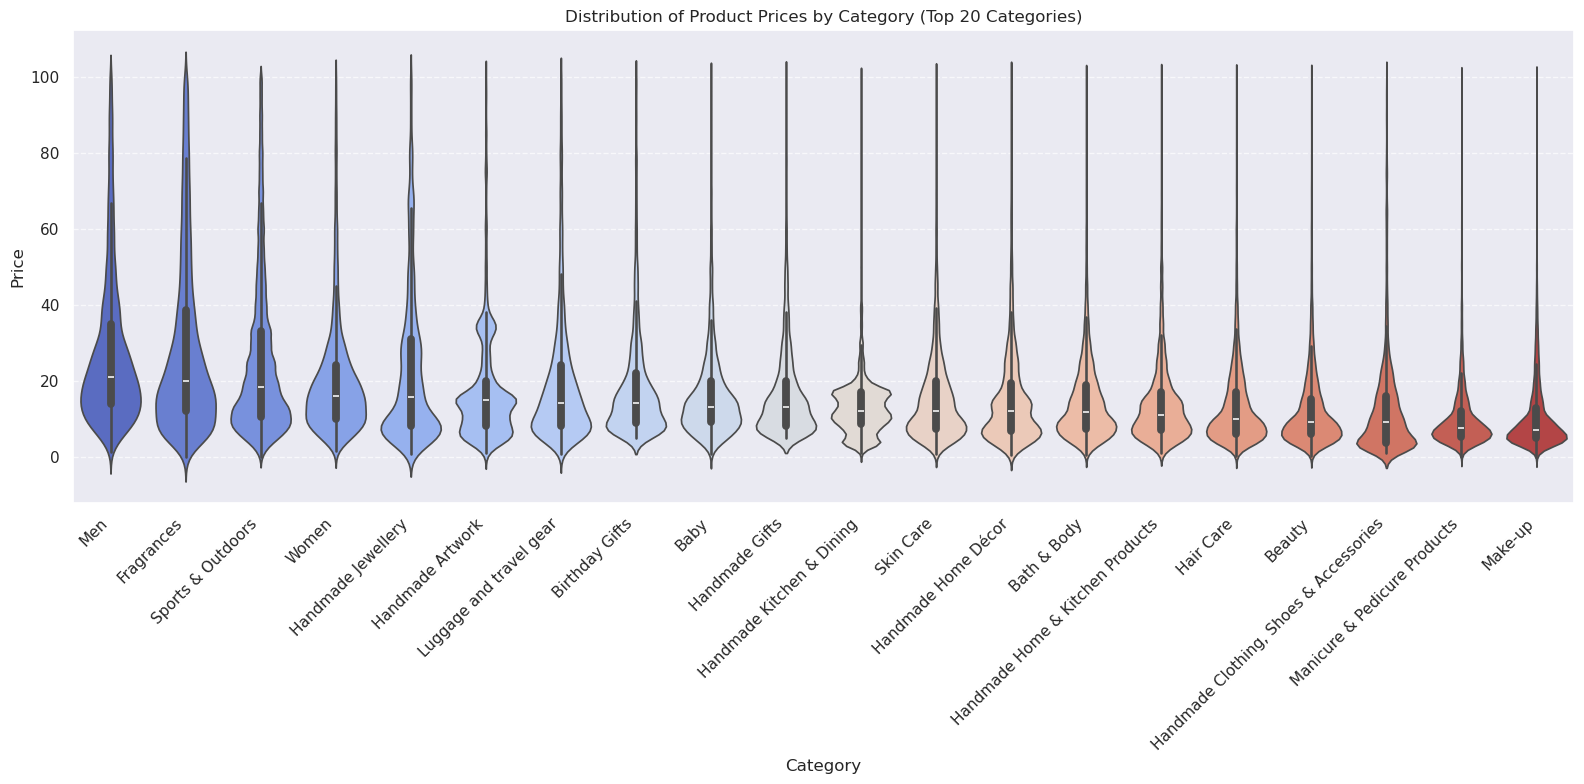

In [38]:
top_20_cats = df_no_outliers['category'].value_counts().nlargest(20).index
df_top_20 = df_no_outliers[df_no_outliers['category'].isin(top_20_cats)]
order_median = (
    df_top_20.groupby('category')['price']
    .median()
    .sort_values(ascending=False)
    .index
)
sns.set_theme(style="dark")
plt.figure(figsize=(16, 8))
sns.violinplot(data=df_top_20, x='category', y='price', hue='category', hue_order=order_median, palette='coolwarm', legend=False, order=order_median)
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Product Prices by Category (Top 20 Categories)')
plt.xlabel('Category')
plt.ylabel('Price')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [39]:
median_series = df_no_outliers.groupby('category')['price'].median().sort_values(ascending=False)
print(f"{median_series.index[0]} has the highest median price, with a value of {median_series.iloc[0]}")

Desktop PCs has the highest median price, with a value of 74.0


In [51]:
print(df[(df['category'] == 'Desktop PCs') & (df['price'] <= 100)][['title', 'price']].head(10))

                                                     title  price
1984949  WiFi enabled Complete set of Dell OptiPlex Dua...  65.00
1984953  Complete set of 21.5in Monitor and Dell OptiPl...  79.15
1984954  Dell OptiPlex Intel i5-2400 Quad Core i5 8GB R...  67.75
1984958  Dell Optiplex 3040 SFF i5 6500 8GB RAM 240GB S...  79.00
1984970  Window 11 Pro Optiplex Core i5 Series Desktop ...  94.80
1984972  HP Elite 8300 SFF Quad Core i5-3470 3.20GHz 8G...  60.00
1984975  BMAX Mini PC B1Plus 6GB RAM/64GB eMMC Intel Ce...  85.99
1984989  Fractal Design Core 1000 USB 3 - Mini Tower Co...  39.98
1984992  HP Elite 8300 SFF Quad Core i5-3470 3.2GHz 8GB...  77.70
1984993  Dell - Complete set of 21.5in Monitor and Dell...  78.00


# Distribution of Product Prices by Category

Observations:

 - Highest Median Price: In the filtered dataset, Desktop PCs holds the highest median price at 74.00.
 - Price Density: Most of the top 20 categories show a "bulbous" shape in the violin plots between 5.00 and 20.00, which aligns with the global median of 15.99 seen in the describe() stats.
 - Low-Price Concentration: Categories like Make-up and Manicure & Pedicure Products have very short and "flat" violins, showing that prices in these segments are heavily concentrated near the bottom of the scale.
 - Price Spread: Categories like Men (clothing), Fragrances, and Sports & Outdoors show longer vertical "necks," indicating a more balanced distribution of prices across the 0 to 100 range.

Key Insights:

 - The Computing Price Floor: After removing outliers (IQR method, limit ~100.00), Desktop PCs ranks at the top. Data inspection confirms these are refurbished enterprise units (e.g., Dell Optiplex, HP Elite). This proves that even legacy computing hardware maintains a higher "entry-level" price than the typical new product in other mass-market categories.
 - Personal Care Price Ceiling: The lower end of the ranking is dominated by Personal Care and Make-up. These categories have the narrowest price distributions, showing that their market is dominated by low-cost items with very little price variation compared to other segments.
 - Market-Wide Variety: Even in "cheaper" categories, the violin plots show "tails" reaching the 100.00 limit. This indicates that price variety exists across the board, although the volume (width of the violin) is always greater at lower price points.

Warnings:

 - Segment Composition: The "Desktop PCs" category in this price range does not represent modern consumer computers, but a specific niche of reconditioned hardware.
 - Median vs. Volume: While Desktop PCs have the highest median, categories like Sports & Outdoors or Beauty likely have a much higher total count of products, making their "bulbous" shapes more representative of the overall Amazon marketplace volume.

#### 2. **Bar Charts**:
    - Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
    - Which product category commands the highest average price? Don't filter here by top categories.

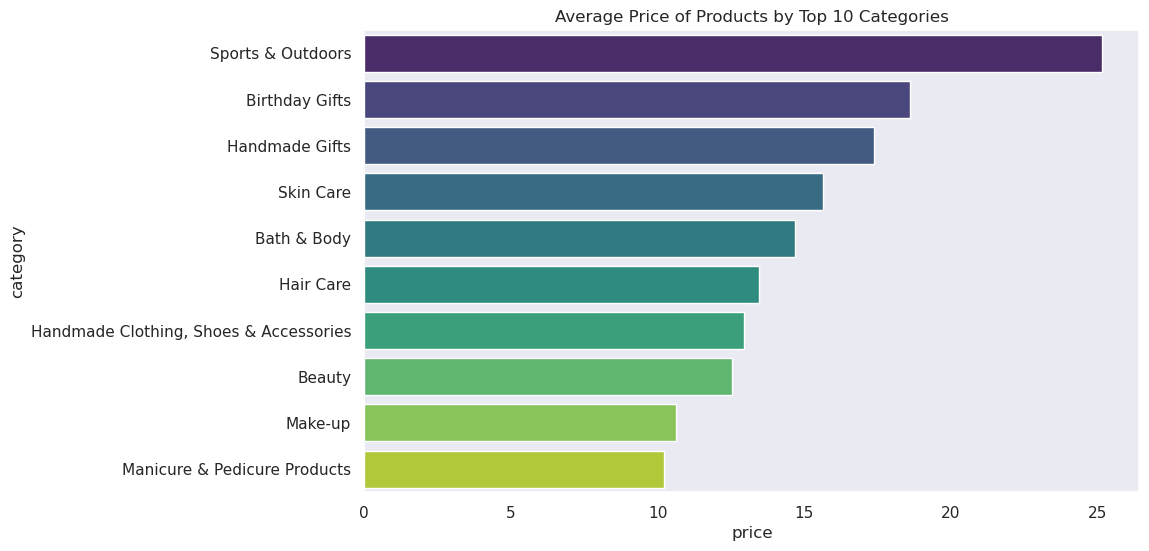

In [40]:
top_10_cats = df_no_outliers['category'].value_counts().nlargest(10).index
df_top_10 = df_no_outliers[df_no_outliers['category'].isin(top_10_cats)]
order_price = df_top_10.groupby('category')['price'].mean().sort_values(ascending=False).index
sns.set_theme(style="dark")
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_top_10,
    palette='viridis',
    y='category', 
    x='price', 
    hue='category', 
    order=order_price,
    hue_order=order_price,
    estimator='mean',
    errorbar=None
)

plt.title('Average Price of Products by Top 10 Categories')
plt.show()

In [41]:
mean_series = df_no_outliers.groupby('category')['price'].mean().sort_values(ascending=False)
print(f"{mean_series.index[0]} has the highest mean price, with a value of {mean_series.iloc[0]:.2f}")

Motherboards has the highest mean price, with a value of 68.77


# Bar Charts: Price Analysis by Category

Observations:

 - Top Category Average: Among the 10 most frequent categories, Sports & Outdoors commands the highest average price, followed by Birthday Gifts and Handmade Gifts.
 - Price Uniformity in Beauty: Categories such as Make-up and Manicure & Pedicure Products show the lowest average prices (around 10.00), reinforcing the earlier observation of high-density, low-cost products in these segments.
 - Global Leader (Unfiltered): When looking at the entire dataset without filtering for frequency, the Motherboards category has the highest mean price overall, with a value of 68.77.

Key Insights:

 - Complexity vs. Price: The fact that Motherboards leads the global mean (68.77) while Desktop PCs leads the median (74.00) confirms that computing and electronics components represent the highest value floor in the marketplace, even after outlier removal.
 - Gift Premium: Categories like Birthday Gifts and Handmade Gifts show higher average prices than standard personal care items, suggesting that consumers are willing to pay a premium for curated or "giftable" items compared to daily essentials.

Technical Note:

 - The bar chart was filtered to the Top 10 categories by count to ensure statistical relevance, avoiding categories with very few items that could skew the visualization. However, the absolute highest mean was calculated across the full dataset to identify the most expensive niche.

#### 3. **Box Plots**:
    - Visualize the distribution of product `ratings` based on their `category` using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
    - Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

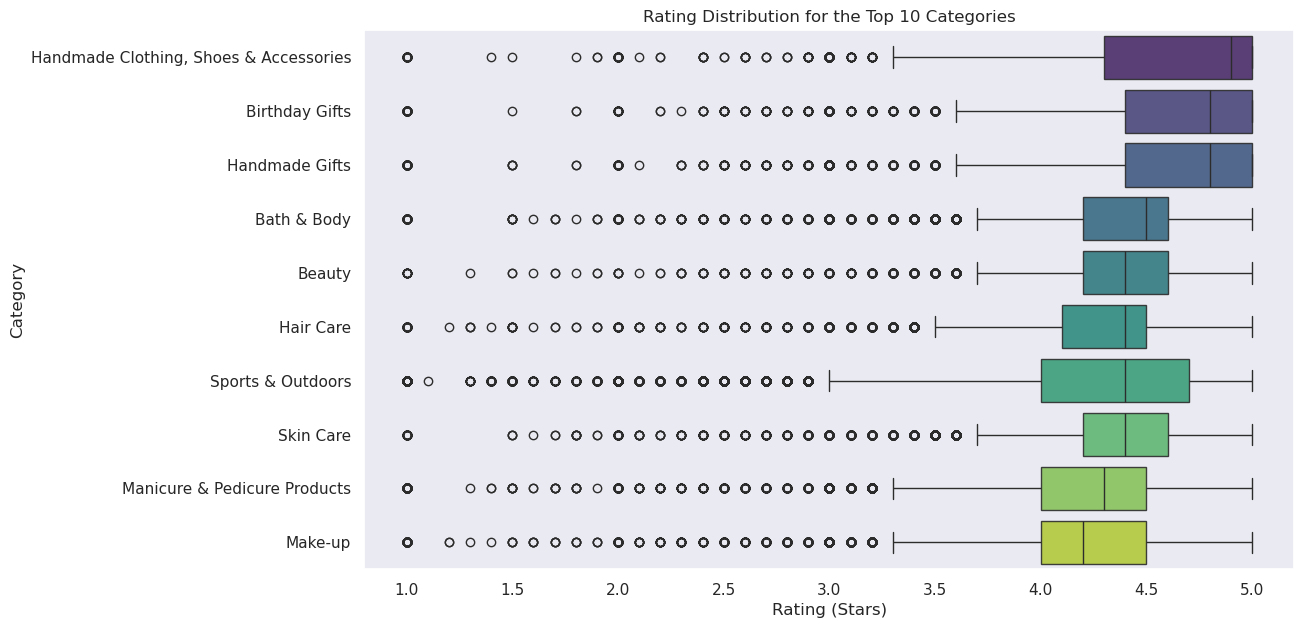

In [42]:
df_plot_stars = df_no_outliers[(df_no_outliers['category'].isin(top_10_cats)) & (df_no_outliers['stars'] > 0)]
order_stars = df_plot_stars.groupby('category')['stars'].median().sort_values(ascending=False).index
plt.figure(figsize=(12, 7))
sns.boxplot(
    data=df_plot_stars,
    x='stars',
    y='category',
    order=order_stars,
    hue='category',
    hue_order=order_stars,
    palette='viridis',
    boxprops=dict(alpha=0.9),
    legend=False
)
plt.title('Rating Distribution for the Top 10 Categories')
plt.xlabel('Rating (Stars)')
plt.ylabel('Category')
plt.show()

In [43]:
df_rates = df_no_outliers[(df_no_outliers['stars'] > 0)]
median_stars_series = df_rates.groupby('category')['stars'].median().sort_values(ascending=False)
print(f"{median_stars_series.index[0]} has the highest median stars, with a value of {median_stars_series.iloc[0]:.2f}")
median_stars_series = df_plot_stars.groupby('category')['stars'].median().sort_values(ascending=False)
print(f"{median_stars_series.index[0]} has the highest median stars, with a value of {median_stars_series.iloc[0]:.2f} between the top 10 categories.")


Handmade Artwork has the highest median stars, with a value of 5.00
Handmade Clothing, Shoes & Accessories has the highest median stars, with a value of 4.90 between the top 10 categories.


In [44]:
count_global = df_rates[df_rates['category'] == 'Handmade Artwork']['stars'].count()
count_top10 = df_rates[df_rates['category'] == 'Handmade Clothing, Shoes & Accessories']['stars'].count()
print(f"Handmade Artwork: {count_global} ratings")
print(f"Handmade Clothing, Shoes & Accessories: {count_top10} ratings")

Handmade Artwork: 4155 ratings
Handmade Clothing, Shoes & Accessories: 4429 ratings


# Box Plots: Rating Distribution by Category

Observations:

 - Top 10 Leader: Among the high-volume categories, Handmade Clothing, Shoes & Accessories holds the highest median rating of 4.90.
 - Global Leader (Unfiltered): Across the entire dataset, Handmade Artwork achieves the highest possible median rating of 5.00.
 - Rating Consistency: Most top categories maintain a median rating above 4.2, but categories like Make-up and Manicure & Pedicure Products show a wider spread of outliers (lower ratings), indicating more varied customer experiences.
 - Volume vs. Satisfaction: Despite being high-volume, both "Handmade" categories maintain an impressive number of ratings (4,155 for Artwork and 4,429 for Clothing), proving that their high scores are statistically significant and not just based on a few reviews.

Key Insights:

 - The "Handmade" Premium: The data reveals a clear trend where handmade categories outperform mass-produced goods in customer satisfaction. This suggests that buyers perceive higher value or quality in unique, artisanal products, leading to near-perfect rating distributions.
 - High Satisfaction Ceiling: Even the "lowest" median in the top 10 (Make-up) sits at approximately 4.2, suggesting a generally positive sentiment across the Amazon marketplace for these leading categories.
 - Niche Excellence: The 5.00 median for Handmade Artwork is a rare statistical feat in large datasets. It indicates a "fan-base" effect where products are either meeting or exceeding expectations almost universally.

Technical Notes & Warnings:

 - Zero-Rating Exclusion: For this analysis, products with 0.0 stars were filtered out. As established previously, these represent a lack of data rather than poor quality, and their inclusion would have skewed the box plots toward zero.
 - Sample Size Validation: Although Handmade Artwork is not in the Top 10 by total count, its sample of over 4,000 ratings confirms that its 5.0 median is robust and representative of actual consumer behavior.
 - Outlier Interpretation: The presence of numerous outliers below the 2.5-star mark in the Beauty and Personal Care segments indicates that while the median is high, these categories are more prone to "hit or miss" products compared to the more consistently rated Handmade sectors.

### Part 3: Investigating the Interplay Between Product Prices and Ratings

**Objective**: Analyze how product ratings (`stars`) correlate with product prices.


#### 1. **Correlation Coefficients**:
    - Calculate the correlation coefficient between `price` and `stars`.
    - Is there a significant correlation between product price and its rating?

In [45]:
pearson = df_rates['price'].corr(df_rates['stars'], method='pearson')
spearman = df_rates['price'].corr(df_rates['stars'], method='spearman')
print(f"Pearson: {pearson:.4f}")
print(f"Spearman: {spearman:.4f}")

Pearson: 0.0067
Spearman: 0.0247


Is there a significant correlation between product price and its rating?
 - No. Both Pearson (0.0067) and Spearman (0.0247) coefficients are extremely close to zero, indicating that there is no significant linear or monotonic correlation between product price and customer ratings in this dataset. This suggests that higher prices do not necessarily result in better reviews.

2. **Visualizations**:
    - Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?

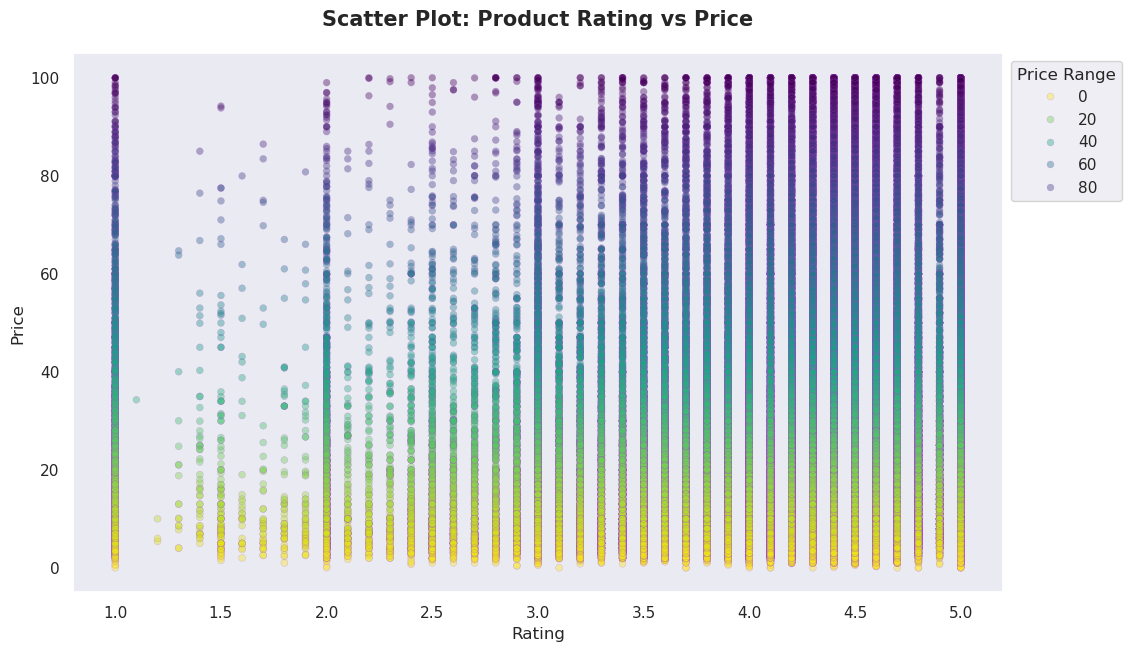

In [46]:
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=df_plot_stars,
    x='stars',
    y='price',
    hue='price',
    palette='viridis_r',
    alpha=0.4,
    edgecolor="#A949D1",
    linewidth=0.25,
    s=25
)
plt.title('Scatter Plot: Product Rating vs Price', fontsize=15, pad=20, fontweight='bold')
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(title="Price Range", loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

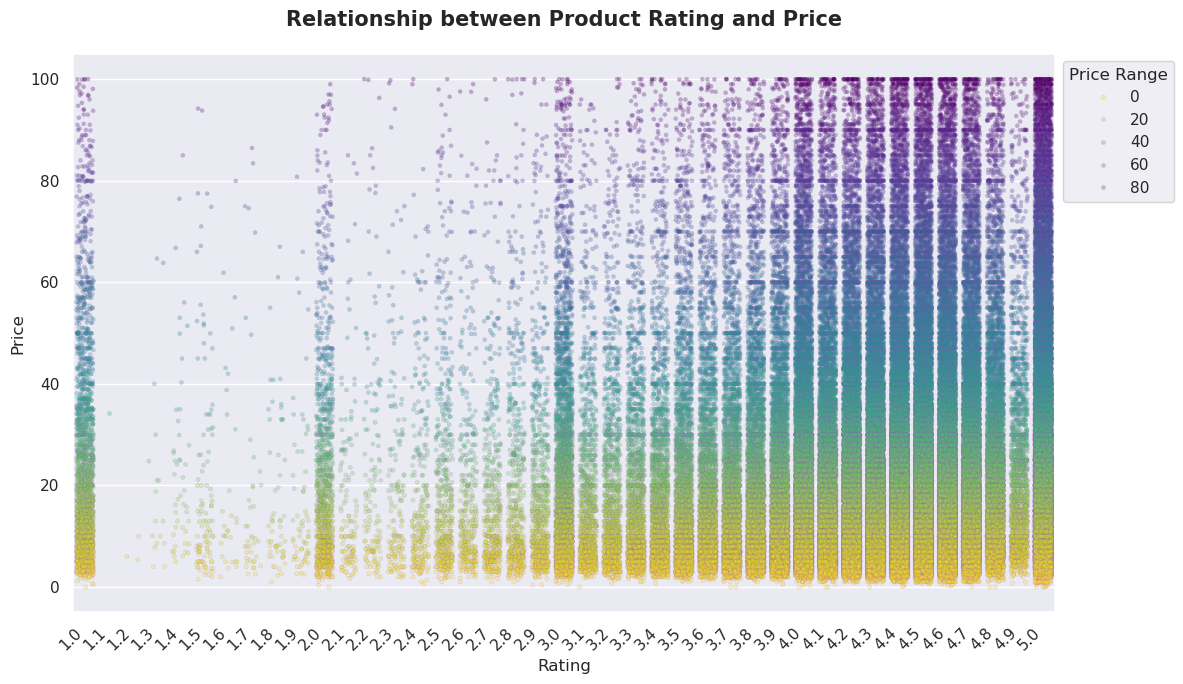

In [47]:
sns.set_style("darkgrid")
plt.figure(figsize=(12, 7))
scatter = sns.stripplot(
    data=df_plot_stars,
    x='stars',
    y='price',
    hue='price',
    hue_norm=(0, 100),
    palette='viridis_r',
    jitter=0.35,
    alpha=0.3,
    edgecolor="#A949D1",
    linewidth=0.25,
    size=3
)
plt.legend(title="Price Range", loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Relationship between Product Rating and Price', fontsize=15, pad=20, fontweight='bold')
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The scatter plot suggests an asymmetric pattern between low and high ratings.
Products with low ratings tend to be concentrated at lower price levels, while higher-rated products are more evenly spread across the full price range up to the 100 limit.
In other words, very expensive items are rarely rated poorly, whereas cheap items can receive both good and bad reviews.
However, this visual tendency is still weak overall, which is consistent with the near-zero Pearson and Spearman correlations reported earlier.

- Use a correlation heatmap to visualize correlations between all numerical variables.

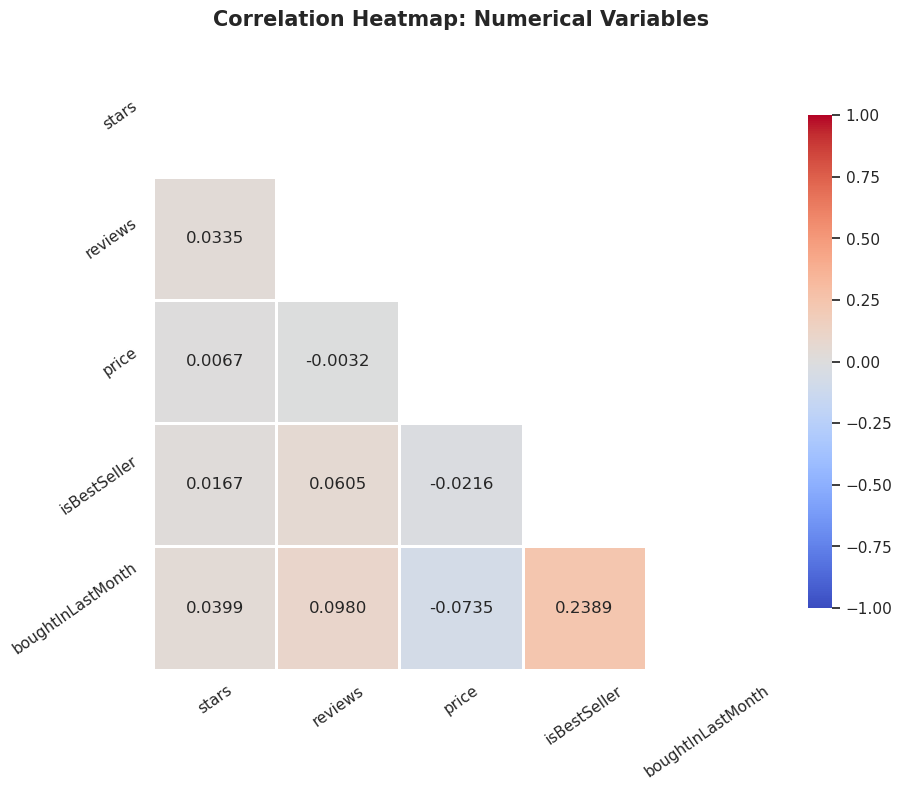

In [48]:
corr_matrix = df_rates.drop(columns=['uid']).corr(numeric_only=True)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(10, 8))
sns.set_style("white")
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    cmap='coolwarm',
    fmt=".4f",
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=1,
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title('Correlation Heatmap: Numerical Variables', fontsize=15, pad=20, fontweight='bold')
plt.xticks(rotation=35)
plt.yticks(rotation=35)
plt.show()

- Examine if product prices typically follow a normal distribution using a QQ plot.

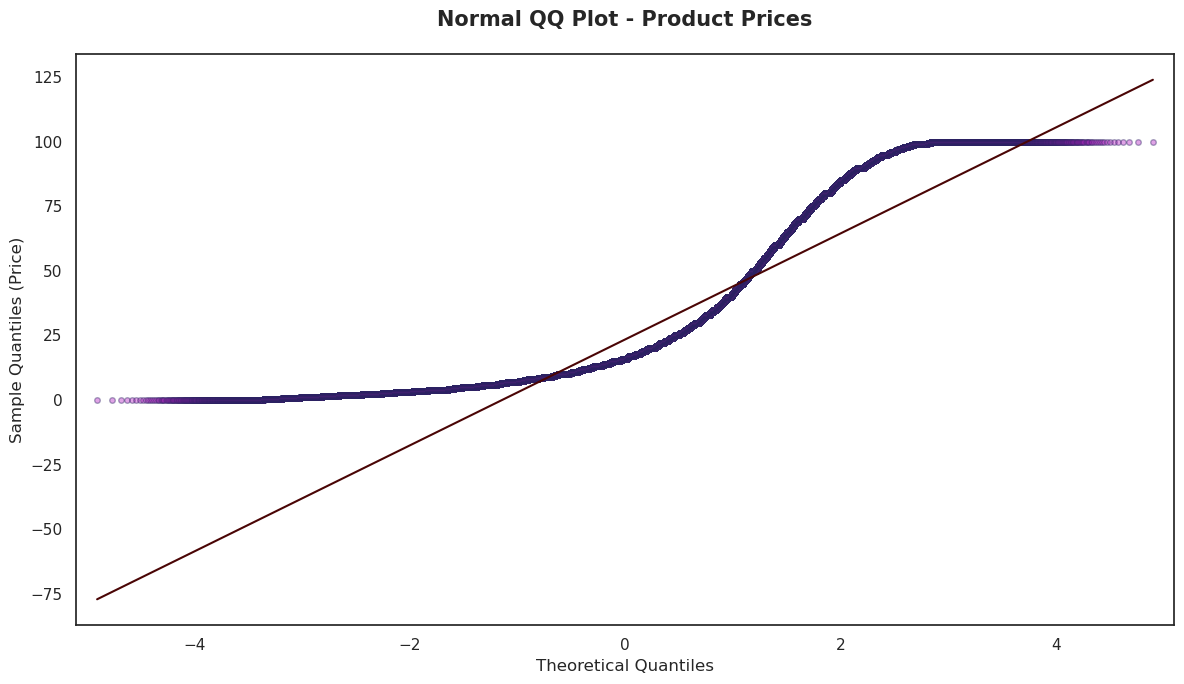

In [49]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.set_style("darkgrid")
sm.qqplot(df_no_outliers['price'], line='s', alpha=0.4, marker='o', markersize=4, ax=ax)
ax.get_lines()[0].set_markerfacecolor("#B31DC1")
ax.get_lines()[0].set_markeredgecolor("#2B2462AA")
ax.get_lines()[1].set_color("#4A0505")
plt.title('Normal QQ Plot - Product Prices', fontsize=15, pad=20, fontweight='bold')
plt.xlabel('Theoretical Quantiles', fontsize=12)
plt.ylabel('Sample Quantiles (Price)', fontsize=12)
plt.tight_layout()
plt.show()

The QQ plot shows a pronounced S‑shaped pattern rather than points closely following the straight reference line. This indicates that product prices do not follow a normal distribution. In particular, the lower tail is compressed near zero and the upper tail is heavier than expected under normality, which is consistent with a right‑skewed distribution dominated by many low‑priced items and a smaller number of relatively expensive products.

## Business Summary

### 1. Best-seller dynamics across categories
- Only a very small share of products in any category achieve Best-Seller status, typically below 6% even in the top-performing segments such as Grocery and Health & Personal Care.
- Niche categories like Smart Home Security & Lighting reach similar or higher best-seller proportions than very large categories, suggesting that it is easier to stand out in specialized segments than in broad, saturated markets like Sports & Outdoors.
- The chi-square test confirms that best-seller status is not randomly distributed across categories, but the low Cramér’s V indicates that category alone is a weak predictor of success. Other factors (price, brand, marketing) are likely more important drivers.

### 2. Price structure in the Amazon UK catalog
- After removing extreme price outliers, most products fall below £30, with a global median price around £16 and a clear right-skewed distribution of prices.
- Desktop PCs show the highest median price among the top categories (~£74), while Motherboards have the highest mean price, confirming that computing hardware and components form the upper price tier of the marketplace.
- Beauty and personal care categories (e.g., Make-up, Manicure & Pedicure Products) are strongly concentrated in the low-price segment, with narrow price ranges and low variability.

### 3. Customer ratings and satisfaction
- Most high-volume categories have median ratings above 4.2 stars once unrated products (0.0 stars) are removed, indicating generally positive customer satisfaction among established products.
- Handmade categories stand out with extremely high median ratings (up to 5.0 stars for Handmade Artwork), suggesting that unique or artisanal products generate stronger perceived value and more enthusiastic feedback.
- At the same time, categories like Make-up and Manicure & Pedicure Products exhibit wider spreads and more low-rating outliers, reflecting more heterogeneous product quality and customer experiences.

### 4. Relationship between price and rating
- Correlation coefficients between price and rating are very close to zero (both Pearson and Spearman), indicating that higher prices do not systematically lead to better ratings.
- The scatter plot shows that low-rated products are mostly concentrated at lower price levels, while highly rated products are spread across the entire price range up to £100. Expensive items are rarely rated poorly, but cheap items can receive both good and bad reviews.
- Overall, price and rating behave as largely independent signals: price captures market positioning, while ratings capture perceived quality, and both should be considered separately in decision-making.

### 5. Implications for business decisions
- For new sellers, entering well-defined niches (e.g., Smart Home, specialized hobbies) may offer a higher relative chance of obtaining a Best-Seller badge than competing directly in broad categories like Sports & Outdoors.
- Pricing strategies should acknowledge that the mass of demand is in the low-to-mid price range, but premium segments such as computing hardware can sustain substantially higher price floors.
- Since ratings do not automatically increase with price, businesses should invest in product quality, service, and review management rather than relying purely on premium pricing to signal value.
